In [1]:
%cd ..

/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark


In [2]:
import sys
sys.path.append('/volatile/home/Zaccharie/workspace/fastmri-reproducible-benchmark')

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import glob
import os
import os.path as op
import random
import time
import warnings
warnings.filterwarnings("ignore")

import h5py
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook

from evaluate import METRIC_FUNCS, Metrics
from fourier import FFT2
from utils import crop_center, gen_mask
from wavelets import WaveletDecimated, WaveletUndecimated

from modopt.opt.linear import Identity
from mri.numerics.reconstruct import sparse_rec_fista
from modopt.opt.proximity import SparseThreshold, LinearCompositionProx
from mri.numerics.gradient import GradAnalysis2

Using TensorFlow backend.



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=0.18.0  - required | 1.3.0     installed
numpy          : >=1.11.0  - required | 1.16.4    installed
matplotlib     : >=2.0.0   - required | 3.1.0     installed
future         : >=0.16.0  - required | 0.17.1    installed
astropy        : ==2.0.8   - required | 2.0.8     installed
nibabel        : >=2.1.0   - required | 2.4.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.1.5   - requi

In [4]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['image.cmap'] = 'gray'

In [5]:
fourier_op = FFT2(np.array([1]))

In [6]:
val_path = '/media/Zaccharie/UHRes/singlecoil_val/'
val_reco_path = '/media/Zaccharie/UHRes/singlecoil_val_reco/'
val_filenames = glob.glob(val_path + '*')

def from_val_file_to_image_and_kspace(filename):
    h5_obj = h5py.File(filename)
    try:
        image = h5_obj['reconstruction_esc'][()]
#         image = h5_obj['reconstruction_rss'][()]
    except:
        print(filename)
        raise
    kspace = h5_obj['kspace'][()]
    h5_obj.close()
    return image, kspace

In [7]:
test_path = '/media/Zaccharie/UHRes/singlecoil_test/'
test_reco_path = '/media/Zaccharie/UHRes/singlecoil_test_reco/'
test_filenames = glob.glob(test_path + '*')

def from_test_file_to_mask_and_kspace(filename):
    h5_obj = h5py.File(filename)
    mask = h5_obj['mask'][()]
    kspace = h5_obj['kspace'][()]
    h5_obj.close()
    return mask, kspace

In [8]:
AF = 4

In [9]:
nb_scales = 4
wavelet_name = 'db4'
    
def reco_from_kspace(kspace, gradient_op, mu=1*1e-8, max_iter=10):
    linear_op = WaveletDecimated(
        nb_scale=nb_scales,
        wavelet_name=wavelet_name,
        padding='periodization',
    )
    
    prox_op = LinearCompositionProx(
        linear_op=linear_op,
        prox_op=SparseThreshold(Identity(), None, thresh_type="soft"),
    )
    gradient_op.obs_data = kspace
    cost_op = None
    x_final, _, _, _ = sparse_rec_fista(
        gradient_op=gradient_op,
        linear_op=Identity(),
        prox_op=prox_op,
        cost_op=cost_op,
        xi_restart=0.96,
        s_greedy=1.1,
        mu=mu,
        restart_strategy='greedy',
        pov='analysis',
        max_nb_of_iter=max_iter,
        metrics=None,
        metric_call_period=1,
        verbose=0,
        progress=False,
    )
#     x_final = gradient_op.fourier_op.adj_op(kspace)
    x_final = np.abs(x_final)
    x_final = crop_center(x_final, 320)
    return x_final

def reco_from_test_file(filename, **kwargs):
    mask, kspaces = from_test_file_to_mask_and_kspace(filename)
    # mask handling
    fake_kspace = np.zeros_like(kspaces[0])
    fourier_mask = np.repeat(mask.astype(np.float)[None, :], fake_kspace.shape[0], axis=0)
    # op creation
    fourier_op_masked = FFT2(mask=fourier_mask)
    gradient_op = GradAnalysis2(
        data=fake_kspace,
        fourier_op=fourier_op_masked,
    )
    im_recos = np.array([reco_from_kspace(kspace * fourier_mask, gradient_op, **kwargs) for kspace in kspaces])
    return im_recos

def reco_from_val_file(filename, accel_factor=AF, **kwargs):
    images, kspaces = from_val_file_to_image_and_kspace(filename)
    # mask gen
    fake_kspace = np.zeros_like(kspaces[0])
    mask = gen_mask(fake_kspace, accel_factor=accel_factor)
    fourier_mask = np.repeat(mask.astype(np.float), fake_kspace.shape[0], axis=0)
    # op creation
    fourier_op_masked = FFT2(mask=fourier_mask)
    masked_kspace = fake_kspace * fourier_mask
    gradient_op = GradAnalysis2(
        data=masked_kspace,
        fourier_op=fourier_op_masked,
    )
    im_recos = np.array([reco_from_kspace(kspace * fourier_mask, gradient_op, **kwargs) for kspace in kspaces[10:20]])
    return im_recos, images[10:20]

Mean of psnr: 27.655572112315
Mean of ssim: 0.60

For mu=5*1e-8,  4 scales, db4, 20 iterations in 1h43 mins

Mean of psnr: 29.5
Mean of ssim: 0.65

For zero-filled

In [10]:
def metrics_for_args(mu=1e-8, max_iter=20, file_prop=0.2):
    metrics = Metrics(METRIC_FUNCS)
    sample_val_filenames = random.sample(val_filenames, int(file_prop * len(val_filenames)))
    pred_and_gt = Parallel(n_jobs=-1, backend='loky')(
        delayed(reco_from_val_file)(val_file, mu=mu, max_iter=max_iter) 
        for val_file in tqdm_notebook(sample_val_filenames)
    )
    
    for im_recos, images in tqdm_notebook(pred_and_gt, desc='Stats'):
        metrics.push(images, im_recos)
    return metrics

For wavelet reco:
- multiprocessing: 4'
- loky: 4'
- multithreading: 4'

In [ ]:
n_exp = 10
mus = np.logspace(-6, -5, n_exp)
# mus = [8*1e-8]
metrics_list = []
for mu in tqdm_notebook(mus):
    print('Testing', mu)
    metrics = metrics_for_args(mu=mu, max_iter=15, file_prop=0.2)
    metrics_list.append(metrics)

Testing 1e-06


In [ ]:
plt.figure()
plt.errorbar(
    mus, 
    [metrics.metrics['PSNR'].mean() for metrics in metrics_list], 
    [metrics.metrics['PSNR'].stddev() for metrics in metrics_list],
    linestyle='None', 
    marker='o',
)
plt.xscale('log')

In [ ]:
plt.figure()
plt.errorbar(
    mus, 
    [metrics.metrics['SSIM'].mean() for metrics in metrics_list], 
    [metrics.metrics['SSIM'].stddev() for metrics in metrics_list],
    linestyle='None', 
    marker='o',
)
plt.xscale('log')

In [23]:
n_exp = 20
mus = np.logspace(-9, -3, n_exp)
# mus = [8*1e-8]
metrics_list = []
for mu in tqdm_notebook(mus):
    print('Testing', mu)
    metrics = metrics_for_args(mu=mu, max_iter=15, file_prop=0.2)
    metrics_list.append(metrics)

Testing 1e-09


Testing 2.06913808111479e-09


Testing 4.281332398719396e-09


Testing 8.858667904100832e-09


Testing 1.8329807108324374e-08


Testing 3.792690190732254e-08


Testing 7.847599703514607e-08


Testing 1.623776739188721e-07


Testing 3.359818286283781e-07


Testing 6.951927961775605e-07


Testing 1.438449888287663e-06


Testing 2.976351441631313e-06


Testing 6.158482110660255e-06


Testing 1.274274985703132e-05


Testing 2.6366508987303556e-05


Testing 5.4555947811685143e-05


Testing 0.00011288378916846884


Testing 0.00023357214690901214


Testing 0.0004832930238571752


Testing 0.001


<IPython.core.display.Javascript object>


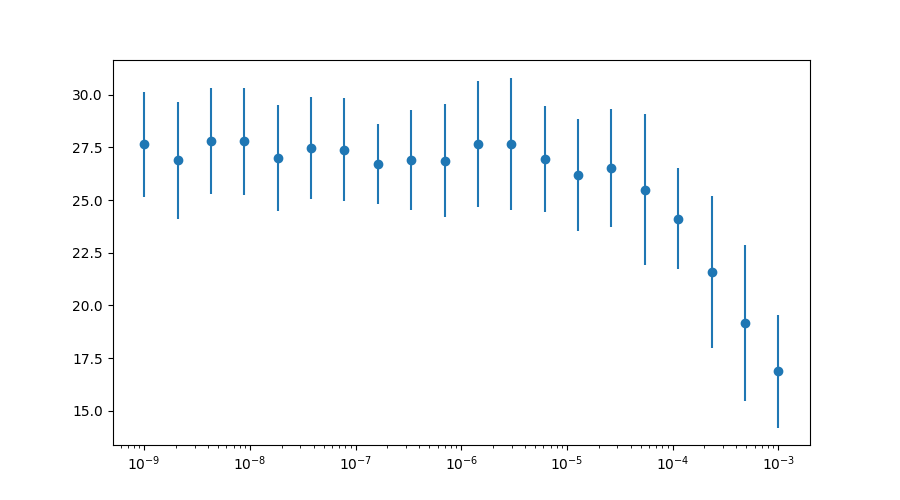

In [24]:
plt.figure()
plt.errorbar(
    mus, 
    [metrics.metrics['PSNR'].mean() for metrics in metrics_list], 
    [metrics.metrics['PSNR'].stddev() for metrics in metrics_list],
    linestyle='None', 
    marker='o',
)
plt.xscale('log')

<IPython.core.display.Javascript object>


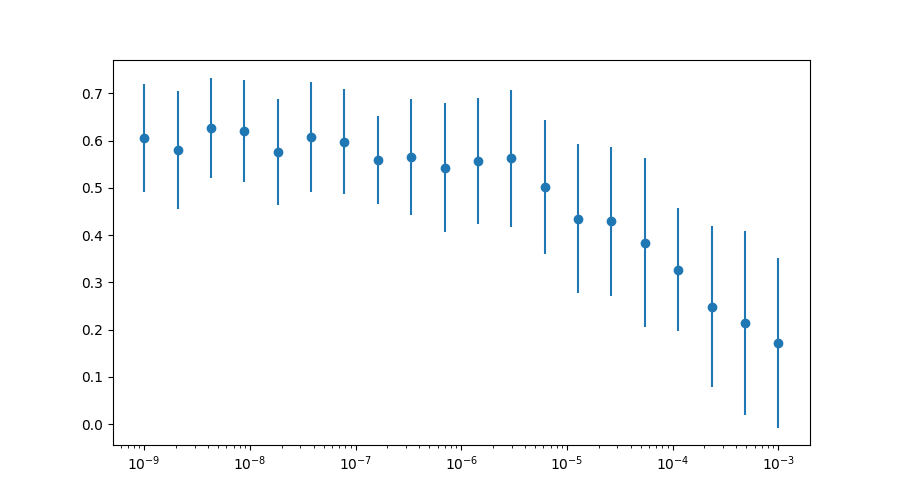

In [25]:
plt.figure()
plt.errorbar(
    mus, 
    [metrics.metrics['SSIM'].mean() for metrics in metrics_list], 
    [metrics.metrics['SSIM'].stddev() for metrics in metrics_list],
    linestyle='None', 
    marker='o',
)
plt.xscale('log')

# Test inference

In [42]:
reco_type = 'zero_filled'

In [43]:
def filename_submission(filename):
    relative_filename = filename.split('/')[-1]
    name = relative_filename.split('.')[0]
    name += '_v2.h5'
    return name
#     return relative_filename

In [44]:
def reco_and_save(filename, path, **kwargs):
    im_recos = reco_from_test_file(filename, **kwargs)
    im_crops = [np.abs(crop_center(im_reco, 320)) for im_reco in im_recos]
    im_crops = np.array(im_crops)
    with h5py.File(op.join(path, reco_type, filename_submission(filename)), 'w') as f:
            f.create_dataset('reconstruction', data=im_crops)

In [45]:
Parallel(n_jobs=-1, backend='multiprocessing', batch_size=len(test_filenames)//40)(
    delayed(reco_and_save)(filename, test_reco_path) for filename in tqdm_notebook(test_filenames)
);